In [4]:
import pandas as pd
import numpy as np
import darts

In [27]:
# Load from file
df = pd.read_csv("../raw_data/20230609-170514-daily-processed-data.csv")

# Change timestamp to column and set as index (needed for darts)
df['timestamp'] = pd.to_datetime(df['timestamp'])
# mega_df.set_index('timestamp', inplace=True)

# # Check
display(df['timestamp'].dtype)# == "datetime64")

# mega_df = mega_df.dropna().drop_duplicates(subset='timestamp').reset_index()
df.head()

dtype('<M8[ns]')

,timestamp,open,high,low,close,volume,volume_CMF,volume_FII,volume_MFI,volume_VWA,...,vortex_pos,S&P_close_filled,Interest_Rates_filled,Inflation_Rate_us,subhag_signal,Fisher,Fisher_trigger,supertrend,chop_index,Velocity
0,2019-09-12,10099.78,10184.66,10081.81,10161.51,621.690,0.008019,9381.841629,54.999476,10062.211552,...,1.084177,3009.57,2.25,1.7,1,1.05901,0.58994,1,55.107287,-1
1,2019-09-13,10321.45,10400.00,10321.45,10388.87,655.809,0.095988,11734.867436,77.615349,10259.840800,...,1.262003,3007.39,2.25,1.7,-1,2.53919,2.24085,1,42.784133,1
2,2019-09-14,10254.01,10299.66,10231.31,10287.11,681.268,0.033290,979.983540,41.709476,10275.093802,...,0.956061,3007.39,2.25,1.7,1,-1.52562,-1.92668,1,56.123524,-1
3,2019-09-15,10395.04,10419.97,10317.39,10377.71,1011.804,0.090962,4476.915550,46.417427,10338.125632,...,1.047632,3007.39,2.25,1.7,-1,2.34801,2.39448,1,49.875268,1
4,2019-09-16,10271.19,10304.56,10266.13,10289.03,834.126,0.021198,-752.692873,34.979972,10292.117754,...,0.947572,2997.96,2.25,1.7,-1,0.00179,0.18466,1,70.808813,-1


In [28]:
df['timestamp']

0      2019-09-12
1      2019-09-13
2      2019-09-14
3      2019-09-15
4      2019-09-16
          ...    
1357   2023-05-31
1358   2023-06-01
1359   2023-06-02
1360   2023-06-03
1361   2023-06-04
Name: timestamp, Length: 1362, dtype: datetime64[ns]

In [29]:
max_nulls = 0

for column in df.columns:
    null_vals = df[column].isna().sum()
    print(f"{column} has {null_vals} values")
    if null_vals > max_nulls:
        max_nulls = null_vals
print(max_nulls)

timestamp has 0 values
open has 0 values
high has 0 values
low has 0 values
close has 0 values
volume has 0 values
volume_CMF has 0 values
volume_FII has 0 values
volume_MFI has 0 values
volume_VWA has 0 values
mom_AOI has 0 values
mom_PPO has 0 values
mom_PPO_signal has 0 values
mom_PVO has 0 values
mom_PVO_signal has 0 values
mom_ROC has 0 values
mom_rsi has 0 values
mom_stoch_RSI has 0 values
mom_StochOscillator has 0 values
mom_StochOscillator_signal has 0 values
mom_TSI has 0 values
mom_UltimateOscillator has 0 values
mom_WilliamsRIndicator has 0 values
volat_ATR has 0 values
volat_bol_hband_binary has 0 values
volat_bol_lband_binary has 0 values
volat_bol_band_width has 0 values
KCW has 0 values
KCP has 0 values
donch_DCW has 0 values
ULI has 0 values
ADX has 0 values
ADX_neg has 0 values
ADX_pos has 0 values
ARI_down has 0 values
ARI has 0 values
ARI_up has 0 values
CCI has 0 values
DPO has 0 values
EMA_100_binary has 0 values
KST has 0 values
KST_diff has 0 values
KST_sig has 0

In [37]:
from darts import TimeSeries
from darts.models import AutoARIMA
from darts.models.forecasting.rnn_model import RNNModel

In [32]:
problem_rows = []
expected_delta = pd.Timedelta(1, 'd')

for i, row in df.iterrows():
    if i != 0:
        if row["timestamp"] - df["timestamp"].iloc[i-1] != expected_delta:
            problem_rows.append(i)
            
problem_rows

[]

In [34]:
series = darts.TimeSeries.from_dataframe(df, 'timestamp', 'close', freq='1d')

train, val = series.split_before(pd.Timestamp('2023-01-01 00:00:00'))

len(train), len(val)

(1207, 155)

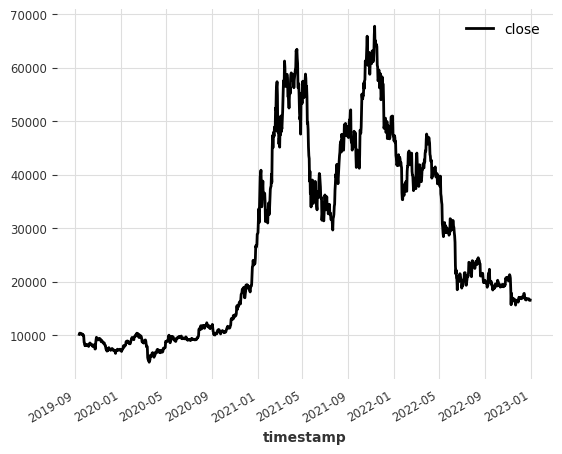

In [35]:
train.plot()

In [45]:
rnn_model = RNNModel(
    input_chunk_length=5,
    model='RNN',
    hidden_dim=64,
    n_rnn_layers=3, 
    dropout=0.6, 
    training_length=24,
    n_epochs=100
)

rnn_model.fit(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 20.9 K
4 | V             | Linear           | 65    
---------------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=RNN, hidden_dim=64, n_rnn_layers=3, dropout=0.6, training_length=24, input_chunk_length=5, n_epochs=100)

In [48]:
prediction = rnn_model.predict(len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

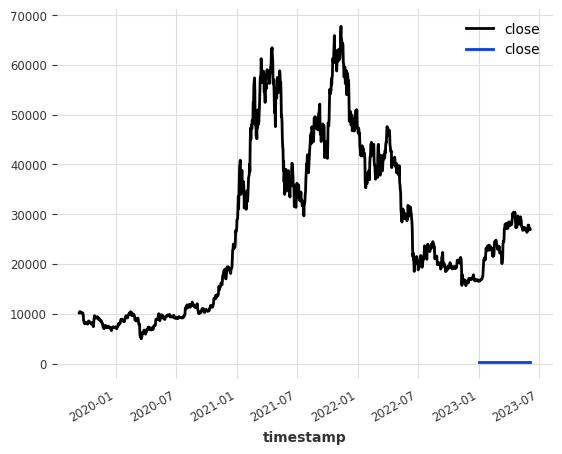

In [49]:
series.plot()
prediction.plot()


In [65]:
aarima_model = AutoARIMA(
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    m=1,
    d=0,
    seasonal=False,
    start_P=0,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True, stepwise=True
)

aarima_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20531.813, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28476.109, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20533.091, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=20533.643, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=26408.045, Time=0.81 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=20535.358, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20531.789, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=25449.292, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20533.407, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=20533.648, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2

AutoARIMA(add_encoders=None, start_p=1, start_q=1, max_p=3, max_q=3, m=1, d=0, seasonal=False, start_P=0, D=None, trace=True, error_action=ignore, suppress_warnings=True, stepwise=True)

In [66]:
prediction = aarima_model.predict(len(val))

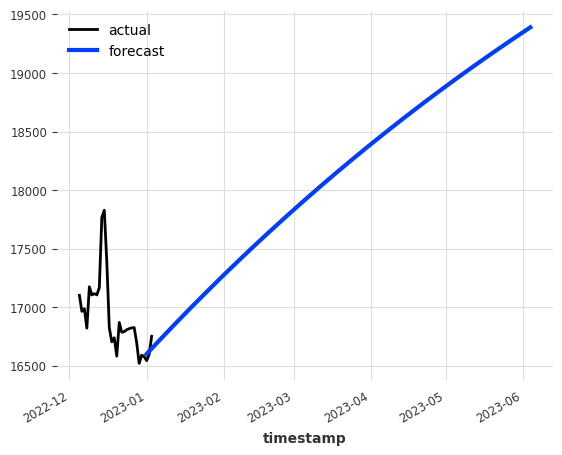

In [72]:
import matplotlib.pyplot as plt

series[1180:1210].plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

In [68]:
# This takes forever to run (hours and hours)

# model = AutoARIMA()

# backtest = model.historical_forecasts(
#     series, 
#     start=0.95, 
#     forecast_horizon=1
# )

In [69]:
prediction

<TimeSeries (DataArray) (timestamp: 155, component: 1, sample: 1)>
array([[[16601.67105931]],

       [[16624.48540798]],

       [[16647.2279989 ]],

       [[16669.89905775]],

       [[16692.49880952]],

       [[16715.02747851]],

       [[16737.48528827]],

       [[16759.8724617 ]],

       [[16782.18922095]],

       [[16804.4357875 ]],

...

       [[19261.41194192]],

       [[19275.86063188]],

       [[19290.26387651]],

       [[19304.62181874]],

       [[19318.93460107]],

       [[19333.20236553]],

       [[19347.42525373]],

       [[19361.6034068 ]],

       [[19375.73696546]],

       [[19389.82606997]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-06-04
  * component  (component) object 'close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None